In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm
import datetime

sns.set_style('darkgrid')
pd.options.display.max_rows = None

In [2]:
transactions = pd.read_csv('../../../data/transactions_train_sample.csv',dtype={"article_id": "str"})
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

<AxesSubplot:xlabel='transaction_count', ylabel='Count'>

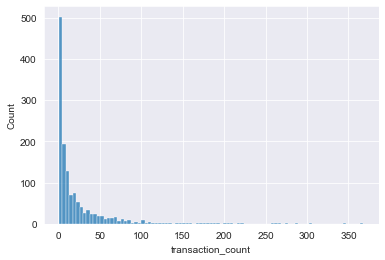

In [3]:
tmp = transactions.groupby('customer_id').article_id.count().reset_index()
tmp.columns = ['customer_id','transaction_count']
sns.histplot(data=tmp,x='transaction_count')

### Map customer_id and article_id to incremental intergers

In [35]:
ALL_USERS = transactions.customer_id.unique().tolist()
ALL_ITEMS = transactions.article_id.unique().tolist()

user_to_customer_map = {u:c for u,c in zip(range(len(ALL_USERS)),ALL_USERS)}
customer_to_user_map = {c:u for u,c in zip(range(len(ALL_USERS)),ALL_USERS)}

item_to_article_map = {i:a for i,a in zip(range(len(ALL_ITEMS)),ALL_ITEMS)}
article_to_item_map = {a:i for i,a in zip(range(len(ALL_ITEMS)),ALL_ITEMS)}

transactions['user_id'] = transactions['customer_id'].map(customer_to_user_map)
transactions['item_id'] = transactions['article_id'].map(article_to_item_map)

In [36]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
0,2018-09-20,1a674938eb6b4f9b3ef35eda901f7c8a319f2666b18241...,0493995001,0.020915,2,0,0
1,2018-09-20,1b291588ef8570d77e354d045dc8041d9235f2437c3d1f...,0669361001,0.042356,1,1,1
2,2018-09-20,1b291588ef8570d77e354d045dc8041d9235f2437c3d1f...,0669361001,0.042356,1,1,1
3,2018-09-20,1dc5a502ddc5c507ddebc319d570e72e27aa3b0cf24ebd...,0661095001,0.059305,1,2,2
4,2018-09-20,3ea749dbef28880a274d2b57172786a846a3da1d5893a3...,0657415005,0.025407,1,3,3


### Build Model

**Configuration parameters**

Since UUCF is very computationally expensive, we only apply on a small subset of users.

We will reduce data base on 2 fronts:
- Keep only the most recent history from `START_DATE`
- Keep only the user with at least `MINIMUM_PURCHASES`

In [44]:
N_SIMILAR_USERS = 30

DROP_PURCHASED_ITEMS = False

DROP_USER_FROM_HIS_NEIGHBORHOOD = True

In [45]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [46]:
def compare_vectors(v1, v2):
    intersection = len(set(v1) & set(v2))
    denominator = np.sqrt(len(v1) * len(v2))
    return intersection / denominator

In [47]:
def get_similar_users(u, v, dfh):
    similar_users = dfh.apply(lambda v_other: compare_vectors(v, v_other)).sort_values(ascending=False).head(N_SIMILAR_USERS + 1)
    
    if DROP_USER_FROM_HIS_NEIGHBORHOOD:
        similar_users = similar_users[similar_users.index != u]
        
    return similar_users.index.tolist(), similar_users.tolist()

In [48]:
def get_items(u, v, dfh):
    global i, n
    
    users, scores = get_similar_users(u, v, dfh)
    df_nn = pd.DataFrame({'user': users, 'score': scores})
    df_nn['items'] = df_nn.apply(lambda row: dfh.loc[row.user], axis=1)
    df_nn['weighted_items'] = df_nn.apply(lambda row: [(item, row.score) for item in row['items']], axis=1)

    recs = pd.DataFrame(flatten(df_nn['weighted_items'].tolist()), columns=['item', 'score']).groupby('item')['score'].sum().sort_values(ascending=False)
    if DROP_PURCHASED_ITEMS:
        recs = recs[~recs.index.isin(v)]
    # Keep the first 12 and get the item_ids
    i +=1
    if i % 200 == 0:
        pid = mp.current_process().pid
        print(f"[PID {pid:>2d}] Finished {i:3d} / {n:5d} - {i/n*100:3.0f}%")
    return recs.head(6).index.tolist()

In [49]:
def get_items_chunk(user_ids: np.array, dfh: pd.DataFrame):
    global i, n
    i = 0
    
    n = len(user_ids)
    pid = mp.current_process().pid
    print(f"[PID {pid:>2d}] Started working with {n:5d} users")
    
    df_user_vectors = pd.DataFrame(dfh.loc[user_ids]).reset_index()
    df_user_vectors['recs'] = df_user_vectors.apply(lambda row: get_items(row.user_id, row.item_id, dfh), axis=1)
    return df_user_vectors.set_index('user_id')['recs']

In [50]:
def get_recommendations(users: list, dfh: pd.DataFrame):
    time_start = time.time()
    
    # Split into approximately evenly sized chunks
    # We will send just one batch to each CPU 
    user_chunks = np.array_split(users, mp.cpu_count())
    
    f = partial(get_items_chunk, dfh=dfh)
    with Pool(mp.cpu_count()) as p:
        res = p.map(f, user_chunks)
    
    df_rec = pd.DataFrame(pd.concat(res))

    elapsed = (time.time() - time_start) / 60
    print(f"Finished get_recommendations({len(users)}). It took {elapsed:5.2f} mins")
    return df_rec

In [56]:
def uucf(df):
    print(f"Total rows: {len(df)}")
    
    # H stands for "Transaction history"
    # dfh is a series of user_id => list of item_id (the list of purchases in order)
    dfh = df.groupby("user_id")['item_id'].apply(lambda items: list(set(items)))
    
    users = dfh.index.tolist()
    n_users = len(users)
    print(f"Total users: {n_users}")
    
    df_rec = get_recommendations(users, dfh)
    df_rec['customer_id'] = df_rec.index.map(user_to_customer_map)
    df_rec['prediction'] = df_rec['recs'].map(lambda l: [item_to_article_map[i] for i in l])
    
    # Submission ready dataframe
    df_rec.reset_index(drop=True)[['customer_id', 'prediction']]
    return df_rec 

### Prediction


In [52]:
import time
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

In [57]:
df_recs = uucf(transactions)

Total rows: 31662
Total users: 1364
[PID 322] Started working with   682 users[PID 323] Started working with   682 users

[PID 323] Finished 200 /   682 -  29%
[PID 322] Finished 200 /   682 -  29%
[PID 323] Finished 400 /   682 -  59%
[PID 322] Finished 400 /   682 -  59%
[PID 323] Finished 600 /   682 -  88%
[PID 322] Finished 600 /   682 -  88%
Finished get_recommendations(1364). It took  0.37 mins


In [58]:
df_recs.head()

,recs,customer_id,prediction
user_id,,,
0,"[15736, 8576, 8578, 2157, 8579, 1973]",1a674938eb6b4f9b3ef35eda901f7c8a319f2666b18241...,"[0894788001, 0696736001, 0751157007, 070113400..."
1,"[2251, 2430, 2164, 5036, 367, 12628]",1b291588ef8570d77e354d045dc8041d9235f2437c3d1f...,"[0706016001, 0706016002, 0554450001, 044850901..."
2,"[10039, 4436, 21, 49, 5533, 8079]",1dc5a502ddc5c507ddebc319d570e72e27aa3b0cf24ebd...,"[0733098011, 0562245050, 0631902001, 067367700..."
3,"[157, 15055, 9485, 6488, 1244, 4988]",3ea749dbef28880a274d2b57172786a846a3da1d5893a3...,"[0108775015, 0861477001, 0554450036, 065829800..."
4,"[12248, 14407, 14058, 13991, 14057, 5636]",4ebffa8ff4c82e506432eb23dc5ad052875e105c934fcd...,"[0599580038, 0833499002, 0688537029, 083353000..."


In [59]:
df_recs = df_recs.drop(['recs'], axis=1)

In [60]:
df_recs.prediction = df_recs.prediction.apply(lambda x: ' '.join(x))

In [61]:
df_recs.head()

,customer_id,prediction
user_id,,
0,1a674938eb6b4f9b3ef35eda901f7c8a319f2666b18241...,0894788001 0696736001 0751157007 0701134009 06...
1,1b291588ef8570d77e354d045dc8041d9235f2437c3d1f...,0706016001 0706016002 0554450001 0448509014 04...
2,1dc5a502ddc5c507ddebc319d570e72e27aa3b0cf24ebd...,0733098011 0562245050 0631902001 0673677002 07...
3,3ea749dbef28880a274d2b57172786a846a3da1d5893a3...,0108775015 0861477001 0554450036 0658298007 06...
4,4ebffa8ff4c82e506432eb23dc5ad052875e105c934fcd...,0599580038 0833499002 0688537029 0833530002 06...


In [62]:
df_recs.to_csv('uucf.csv',index=False)

### Visulize Prediction

In [24]:
import math

In [4]:
df_recs = pd.read_csv('uucf.csv')

cus_id: 04198da22f804f2568793cd20a72e35f3f42f42d2b697434597f65cecf004e98
pred: ['0706016001', '0706016002', '0108775015', '0673396002', '0372860001', '0599580017']
last_purchase: ['0108775015', '0539723001', '0667499004', '0292551001', '0631649002', '0528070001', '0657795003', '0634009010', '0709504001', '0453585016', '0698302015', '0735840004', '0574109017', '0698317002', '0539723004', '0605094024', '0708626002', '0682236001', '0706016002', '0678687013', '0706016001', '0243937001', '0678687016', '0605093008', '0753708001', '0705732003', '0372860001', '0673396002', '0721136005', '0685012004', '0711053009', '0677930026', '0677930037', '0686655001', '0717490010', '0680262010', '0734460001', '0710056003', '0753282002', '0189634001', '0747946003', '0717490012', '0189616001', '0677930015', '0633130007', '0562613011', '0762751002', '0796210002', '0781592001', '0598515020', '0562613013', '0636323001', '0663519001', '0716590001', '0837249001', '0547780001', '0547780002', '0794575001', '0547780

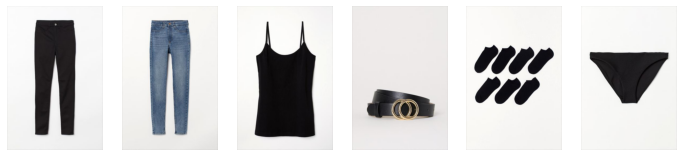

Last Purchase


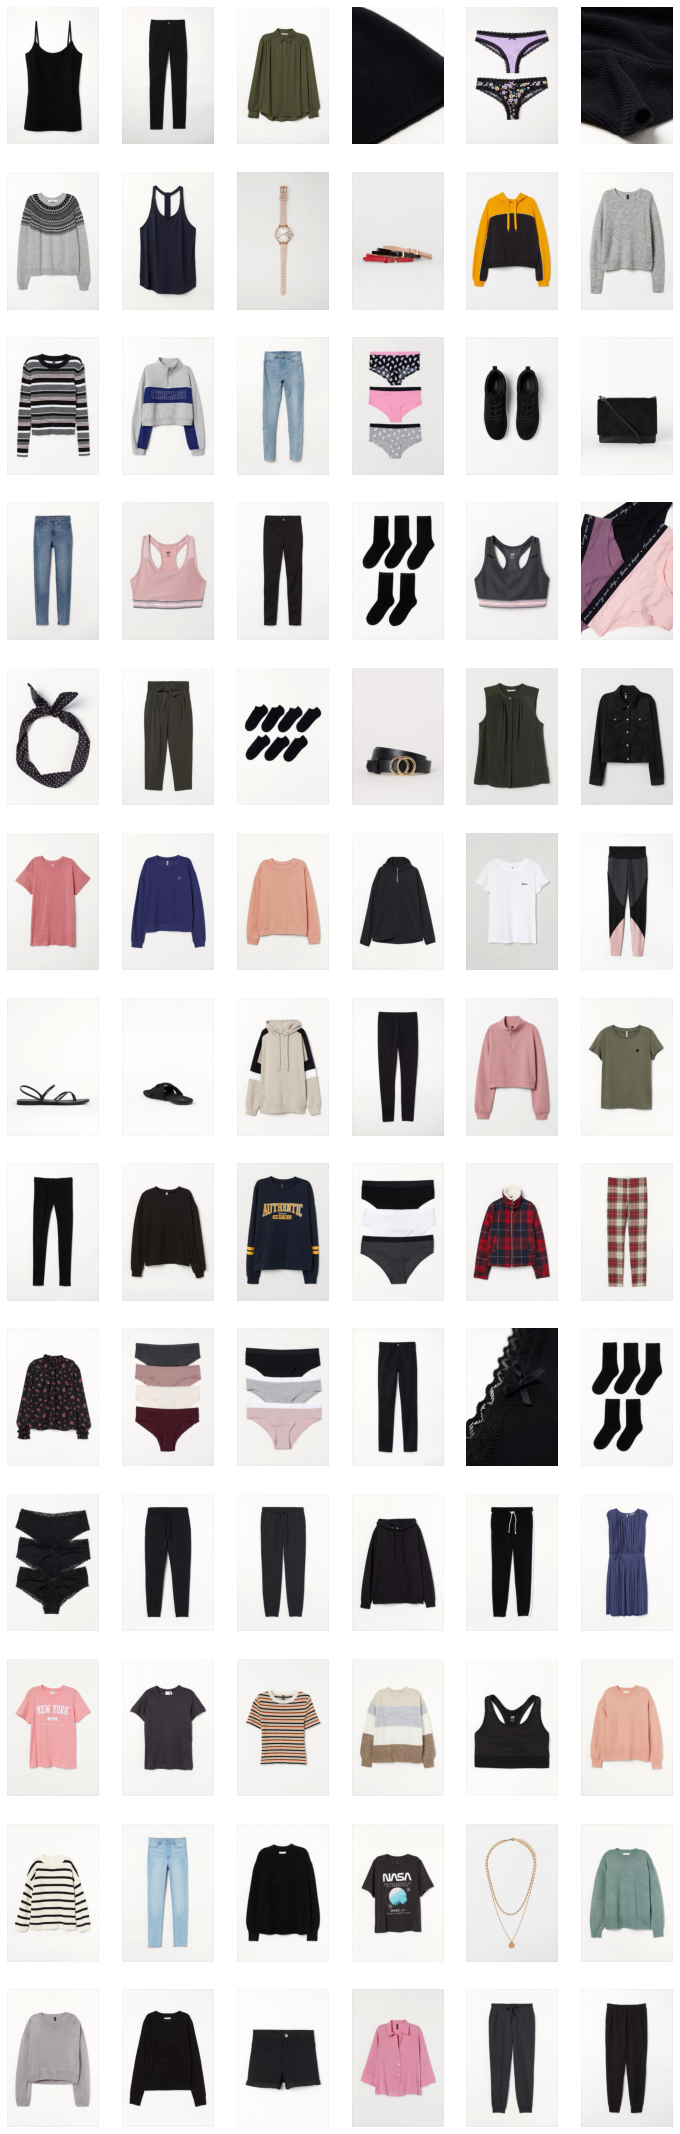

In [39]:
index = 50

cus_id = df_recs.loc[index,'customer_id']
pred = df_recs.loc[index,'prediction'].split(' ')
last_purchase = list(transactions.loc[
    transactions.customer_id == cus_id,
    'article_id'].unique())

print('cus_id:',cus_id)
print('pred:', pred)
print('last_purchase:', last_purchase)

print('Prediction')
fig,axes = plt.subplots(nrows=1,ncols=6,figsize=(12,3))
axes = axes.flatten()
for im_id,ax in zip(pred,axes):
    ax.axis('off')
    im = plt.imread(f'../../../data/images/{im_id[:3]}/{im_id}.jpg')
    ax.imshow(im)
plt.show()

print('Last Purchase')
nr = math.ceil(len(last_purchase)/6)
fig,axes = plt.subplots(nrows=nr,ncols=6,figsize=(12,nr*3))
axes = axes.flatten()
last_purchase += [None]*(nr*6-len(last_purchase))
for im_id,ax in zip(last_purchase,axes):
    ax.axis('off')
    if im_id is not None:
        im = plt.imread(f'../../../data/images/{im_id[:3]}/{im_id}.jpg')
        ax.imshow(im)
plt.show()